Download the dataset

In [1]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
!gdown 12p89HvgO7AMDpyKb_pdZ-4HUYueoJcrG
!gdown 1jEV_quP2CSd2OdZWAXSO6sQAnNrAzsvM
!gdown 1dAmX_mFB_lCSKCHjAVCHm21Vfg6jqGho

Downloading...
From (uriginal): https://drive.google.com/uc?id=12p89HvgO7AMDpyKb_pdZ-4HUYueoJcrG
From (redirected): https://drive.google.com/uc?id=12p89HvgO7AMDpyKb_pdZ-4HUYueoJcrG&confirm=t&uuid=ba260811-e6c0-46c1-b582-e67431aedf23
To: /content/Red onion.zip
100% 3.79G/3.79G [00:23<00:00, 160MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1jEV_quP2CSd2OdZWAXSO6sQAnNrAzsvM
From (redirected): https://drive.google.com/uc?id=1jEV_quP2CSd2OdZWAXSO6sQAnNrAzsvM&confirm=t&uuid=a682b9df-df20-41e6-b856-223767bbea70
To: /content/Pumpkin.zip
100% 3.58G/3.58G [00:23<00:00, 151MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1dAmX_mFB_lCSKCHjAVCHm21Vfg6jqGho
From (redirected): https://drive.google.com/uc?id=1dAmX_mFB_lCSKCHjAVCHm21Vfg6jqGho&confirm=t&uuid=e55c4339-0e8e-4199-9c39-6cbbb13147e8
To: /content/Beetroot.zip
100% 3.60G/3.60G [00:21<00:00, 166MB/s]


In [3]:
!unzip /content/Red_onion.zip
!unzip /content/Pumpkin.zip
!unzip /content/Beetroot.zip

Archive:  /content/Red_onion.zip
  inflating: Red onion/20230321_172150.jpg  
  inflating: Red onion/20230321_172151.jpg  
  inflating: Red onion/20230321_172152.jpg  
  inflating: Red onion/20230321_172153.jpg  
  inflating: Red onion/20230321_172154.jpg  
  inflating: Red onion/20230321_172155.jpg  
  inflating: Red onion/20230321_172157.jpg  
  inflating: Red onion/20230321_172158.jpg  
  inflating: Red onion/20230321_172159.jpg  
  inflating: Red onion/20230321_172200.jpg  
  inflating: Red onion/20230321_172201.jpg  
  inflating: Red onion/20230321_172202.jpg  
  inflating: Red onion/20230321_172204.jpg  
  inflating: Red onion/20230321_172206.jpg  
  inflating: Red onion/20230321_172207.jpg  
  inflating: Red onion/20230321_172208.jpg  
  inflating: Red onion/20230321_172210.jpg  
  inflating: Red onion/20230321_172211.jpg  
  inflating: Red onion/20230321_172214.jpg  
  inflating: Red onion/20230321_172215.jpg  
  inflating: Red onion/20230321_172216.jpg  
  inflating: Red onion

Import necessary libraries

In [4]:
import os
import pandas as pd
import numpy as np
import shutil, math, cv2, json, random
from tqdm import tqdm
from keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Preprocess the dataset

In [5]:
sdir = '/content/Dataset'

def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    os.remove(fpath)
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    return train_df, test_df, valid_df, classes, class_count


train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

Red onion              : 100%|██████████████████████████████████████████| 1000/1000 [04:18<00:00,  3.87file/s]


number of classes in processed dataset=  3
the maximum files in any class in train_df is  800   the minimum files in any class in train_df is  800
train_df length:  2400   test_df length:  300   valid_df length:  300
average image height=  3952   average image width=  3328  aspect ratio h/w=  1.1875


In [22]:
def normalized_data(img):
    # Normalise the data sample by applying the average pixel value
    img = (img.astype(np.float32) / 127.5) - 1

    # Apply standard deviation
    img /= (np.std(img, axis=(0,1)) + 1e-7)

    return img

In [21]:
batch_size = 8
img_size = (224, 224)
input_shape = (224, 224, 3)
color = 'rgb'

def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(
        preprocessing_function=lambda img: normalized_data(img))
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode=color, batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode=color, batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode=color, batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 2400 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
test batch size:  75 test steps:  4 number of classes :  3


### **Construct the neural network**

Create & Compile the model

In [57]:
from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, concatenate, Dropout

# Load pretrained ResNet50 and VGG16 models
resnet_model = ResNet50(weights='imagenet', include_top=False)
vgg_model = VGG16(weights='imagenet', include_top=False)
vgg_model_1 = VGG19(weights='imagenet', include_top=False)

# Freeze the layers in the models
for layer in resnet_model.layers:
    layer.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
for layer in vgg_model_1.layers:
    layer.trainable = False

# Define inputs
input_tensor = Input(shape=input_shape)

# Get the outputs from the pretrained models
resnet_output = resnet_model(input_tensor)
vgg_output = vgg_model(input_tensor)
vgg_output_1 = vgg_model_1(input_tensor)

# Concatenate the outputs
merged = concatenate([resnet_output, vgg_output, vgg_output_1])

# Add a global average pooling layer
pooled = GlobalAveragePooling2D()(merged)

# Add a dropout layer
dropout_1 = Dropout(0.5)(pooled)

dense_1 = Dense(128, activation='relu')(dropout_1)

dropout_2 = Dropout(0.5)(dense_1)

# Add a final dense layer with 3 units
predictions = Dense(3, activation='softmax')(dropout_2)

# Create the model
model = Model(inputs=input_tensor, outputs=predictions)

#Construct activation layer
model.compile(optimizer='SGD', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'AUC'])

model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, None, None,   23587712    ['input_80[0][0]']               
                                2048)                                                             
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_80[0][0]']               
                                512)                                                       

Train the model

In [58]:
history = model.fit(train_ds, epochs=1, batch_size=batch_size, validation_data=valid_ds)

300/300 [==============================] - 671s 2s/step - loss: 0.6351 - accuracy: 0.7362 - auc: 0.8949 - val_loss: 0.2234 - val_accuracy: 0.9333 - val_auc: 0.9862


Plot the loss, accuracy, and AUC

CNNM_Matrix
38/38 [==============================] - 74s 2s/step
there were 29 errors in 300 tests for an accuracy of  90.33%


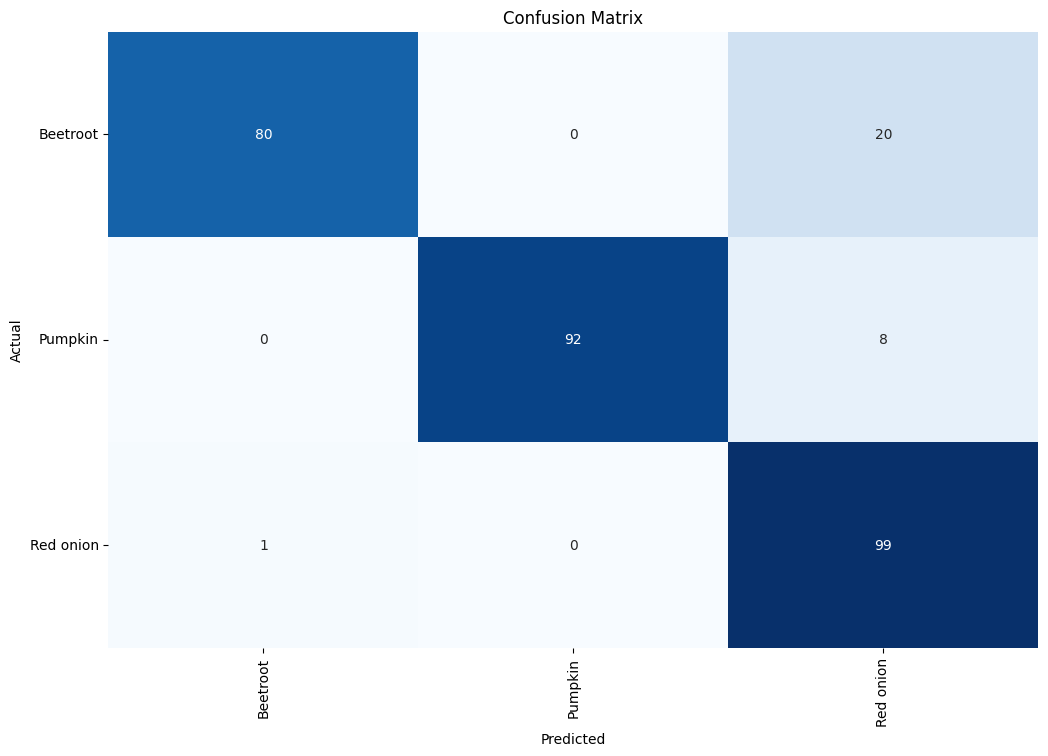



Classification Report:
----------------------
               precision    recall  f1-score   support

    Beetroot     0.9877    0.8000    0.8840       100
     Pumpkin     1.0000    0.9200    0.9583       100
   Red onion     0.7795    0.9900    0.8722       100

    accuracy                         0.9033       300
   macro avg     0.9224    0.9033    0.9049       300
weighted avg     0.9224    0.9033    0.9049       300



In [59]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def predictor(test_ds):
    print("CNNM_Matrix")
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    pdct = model.predict(test_ds)
    preds = tf.argmax(pdct, axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("\n\nClassification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_ds)

Confusion matrix

In [60]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [62]:
# Save model to Google Drive
model.save('my_second_final_model.h5')